# Sampling and Weight

Let's make the label of the return of the stock from Monday to Friday and the return from Wednesday to Friday that week. The label is the sign of the return. Then the information used to make these two labels has overlapping parts from Wednesday to Friday. As such, there is an overlapping label problem with financial data. we can address the problem of non-IID labels by designing sampling and weighting schemes.

In [1]:
import mlfinlab as ml

import numpy as np
import pandas as pd

In [2]:
dollar_bars = pd.read_csv('sample_dollar_bars.csv', nrows=40000)
dollar_bars

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499
...,...,...,...,...,...,...,...
2012-07-30 12:30:28.642,1379.25,1380.00,1377.50,1377.75,50843,70116589.50,17923
2012-07-30 13:29:21.258,1377.75,1380.00,1377.00,1379.25,50782,70014483.25,14040
2012-07-30 13:35:05.407,1379.25,1383.25,1379.00,1382.50,50675,70001889.25,12017


In [3]:
barrier_events = pd.read_csv('barrier_events.csv', index_col=0, parse_dates=[0,1])
barrier_events

,t1
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326000128
2011-08-04 09:53:01.844,2011-08-04 13:50:40.606000128
2011-08-04 19:30:23.101,2011-08-04 20:01:48.966000128
2011-08-04 19:59:41.879,2011-08-05 12:30:19.803000064
2011-08-05 12:30:19.803,2011-08-05 13:51:55.448999936
...,...
2012-06-10 22:00:00.149,2012-06-11 14:00:08.657999872
2012-06-11 13:41:07.758,2012-06-11 19:10:45.499000064
2012-06-29 12:37:47.020,2012-07-02 02:39:19.100999936
2012-06-29 19:59:53.768,2012-07-02 02:39:19.100999936


---

## Sample Uniqueness

In [4]:
from mlfinlab.sampling.concurrent import get_av_uniqueness_from_triple_barrier, num_concurrent_events

### Calculating average uniqueness of a label

We need to have metrics for calculating the uniqueness of sample to use the data accordingly.

In [5]:
av_unique = get_av_uniqueness_from_triple_barrier(barrier_events, dollar_bars.close, num_threads=3)
av_unique

2020-04-11 13:20:51.355499 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:20:51.461217 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


,tW
2011-08-04 01:57:00.466,0.833333
2011-08-04 09:53:01.844,0.937500
2011-08-04 19:30:23.101,0.892857
2011-08-04 19:59:41.879,0.888889
2011-08-05 12:30:19.803,0.928571
...,...
2012-06-10 22:00:00.149,0.875000
2012-06-11 13:41:07.758,0.948276
2012-06-29 12:37:47.020,0.923077
2012-06-29 19:59:53.768,0.500000


### Computing the number of concurrent events

In [6]:
num_conc_events = num_concurrent_events(close_series_index=dollar_bars.index,
                                        label_endtime=barrier_events['t1'],
                                        molecule=barrier_events.index
                                       )
num_conc_events

date_time
2011-08-04 01:57:00.466    1
2011-08-04 07:02:07.951    1
2011-08-04 08:04:23.710    1
2011-08-04 09:08:28.542    1
2011-08-04 09:53:01.844    2
                          ..
2012-07-03 16:59:59.054    1
2012-07-03 17:13:10.659    1
2012-07-04 07:53:36.687    1
2012-07-04 13:37:39.125    1
2012-07-05 06:25:06.504    1
Length: 9185, dtype: int64

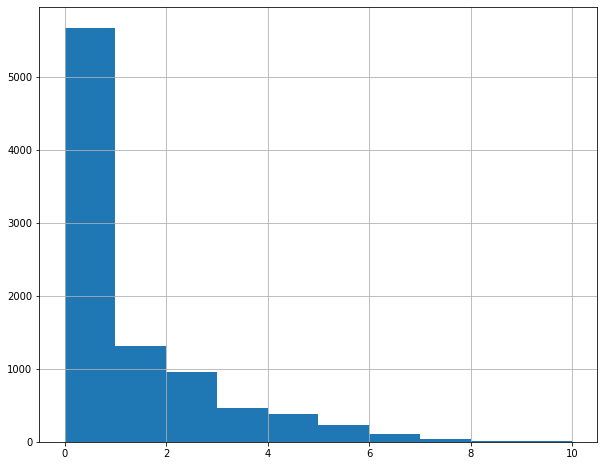

In [7]:
num_conc_events.hist(figsize=(10,8))

---

## Sequential Bootstrapping

We know that most financial data is not independent and has a non-IID label issue. So we need to be careful in the bootstrapping process. In the bootstrapping procedure, we should not randomly select the next sample, but we should compare the samples we have already selected with the entire sample to adjust the sampling probability so that there are fewer overlapping samples. We call this _Sequential Bootstrap_. Through sequential bootstrap, we can maximize the uniqueness of subsamples and use them as training sets for the model such as random forests.

In [8]:
from mlfinlab.sampling.bootstrapping import get_ind_matrix, get_ind_mat_average_uniqueness, get_ind_mat_label_uniqueness
from mlfinlab.sampling.bootstrapping import seq_bootstrap

### Build an indicator matrix

The indicator matrix is a binary matrix indicating what bars influence the label for each observation. It is a very useful structure for caculating uniqueness of samples and used in sequential bootstrapping

we assume that the method ```get_ind_matrix``` is used for _triple barrier events_. So, index of series data which is used in the method should be the time when event is triggered and value of series should be the time when event is finished. Also, name of the series should be _'t1'_

In [9]:
barrier_events_series = barrier_events['t1']
barrier_events_series

2011-08-04 01:57:00.466   2011-08-04 10:27:24.326000128
2011-08-04 09:53:01.844   2011-08-04 13:50:40.606000128
2011-08-04 19:30:23.101   2011-08-04 20:01:48.966000128
2011-08-04 19:59:41.879   2011-08-05 12:30:19.803000064
2011-08-05 12:30:19.803   2011-08-05 13:51:55.448999936
                                       ...             
2012-06-10 22:00:00.149   2012-06-11 14:00:08.657999872
2012-06-11 13:41:07.758   2012-06-11 19:10:45.499000064
2012-06-29 12:37:47.020   2012-07-02 02:39:19.100999936
2012-06-29 19:59:53.768   2012-07-02 02:39:19.100999936
2012-07-03 14:01:45.765   2012-07-05 06:25:06.504000000
Name: t1, Length: 337, dtype: datetime64[ns]

In [10]:
barrier_events['t1'].name

't1'

In [11]:
triple_barrier_ind_mat = get_ind_matrix(barrier_events_series, dollar_bars)
triple_barrier_ind_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Computing average uniqueness of indicator matrix

we can get the average uniqueness of our samples.

In [13]:
np.seterr(divide='ignore')
ind_mat_uniqueness = get_ind_mat_average_uniqueness(triple_barrier_ind_mat)
ind_mat_uniqueness

0.40972604246891847

### Generate samples

Here we generate 337 samples of the same size as the original sample. We take the first sample from the first sample to the fifth sample and draw the remaining 332 data through the bootstrap. We can confirm that the sequential bootstrap method can obtain a sample with higher specificity of the sample than the standard bootstap method.

In [14]:
original_sample_length = triple_barrier_ind_mat.shape[1]
original_sample_length

337

In [16]:
np.seterr(divide='ignore')
samples = seq_bootstrap(ind_mat=triple_barrier_ind_mat,
                        sample_length=original_sample_length,
                        warmup_samples=[0, 1, 2, 3, 4, 5],
                        compare=True
                       )

Standard uniqueness: 0.34732435795904515
Sequential uniqueness: 0.3813139650049521


---

## Sample Weights

In addition to bringing bootstrap samples closer to the IID, we can give the model better information by considering the time and the size of return of the samples with uniqueness.

### Return attribution

Labels with higher absolute returns may be considered more important than labels with lower absolute returns. Therefore, we can calculate the sample weight by taking into account the absolute return with the uniqueness.

In [17]:
from mlfinlab.sample_weights import get_weights_by_return
from mlfinlab.sample_weights import get_weights_by_time_decay

In [18]:
sample_weights_by_return = get_weights_by_return(barrier_events,
                                                 dollar_bars['close']
                                                )
sample_weights_by_return

2020-04-11 13:21:14.789172 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:14.941564 100.0% _apply_weight_by_return done after 0.0 minutes. Remaining 0.0 minutes.


2011-08-04 01:57:00.466    1.311463
2011-08-04 09:53:01.844    2.197941
2011-08-04 19:30:23.101    2.289995
2011-08-04 19:59:41.879    1.648158
2011-08-05 12:30:19.803    0.324506
                             ...   
2012-06-10 22:00:00.149    0.807211
2012-06-11 13:41:07.758    2.280080
2012-06-29 12:37:47.020    2.003358
2012-06-29 19:59:53.768    0.201167
2012-07-03 14:01:45.765    0.327673
Length: 337, dtype: float64

### Time decay

As markets evolve, recent observations may be more important than old ones. We can reflect that parts into the sample weight through the _decay_ parameter.

- $dacay=1:$ There  is no time decay.
- $0<dacay<1:$ weights decay linearly over time, but every observation but every observation still receives a strictly positive weight, regardless of how old
- $decay=0:$ means that weights converge linearly to zero, as they become older
- $decay<0:$ means that the oldes portion c of the observations receive zero weight (i.e they are erased from memory)
    

In [19]:
sample_weights_by_time = get_weights_by_time_decay(barrier_events,
                                                   dollar_bars['close'],
                                                   decay=1
                                                  )
sample_weights_by_time

2020-04-11 13:21:16.659131 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:16.790568 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


2011-08-04 01:57:00.466    1.0
2011-08-04 09:53:01.844    1.0
2011-08-04 19:30:23.101    1.0
2011-08-04 19:59:41.879    1.0
2011-08-05 12:30:19.803    1.0
                          ... 
2012-06-10 22:00:00.149    1.0
2012-06-11 13:41:07.758    1.0
2012-06-29 12:37:47.020    1.0
2012-06-29 19:59:53.768    1.0
2012-07-03 14:01:45.765    1.0
Name: tW, Length: 337, dtype: float64

In [20]:
sample_weights = pd.DataFrame()
decay_list = [-0.5, 0, 0.5, 1]
for c in decay_list:
    sample_weights[str(c)] = get_weights_by_time_decay(barrier_events,
                                                       dollar_bars['close'],
                                                       decay=c
                                                      )

2020-04-11 13:21:17.335198 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:17.491370 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:17.683520 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:17.863559 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:18.037567 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:18.234941 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:18.445557 100.0% num_concurrent_events done after 0.0 minutes. Remaining 0.0 minutes.
2020-04-11 13:21:18.608688 100.0% _get_average_uniqueness done after 0.0 minutes. Remaining 0.0 minutes.


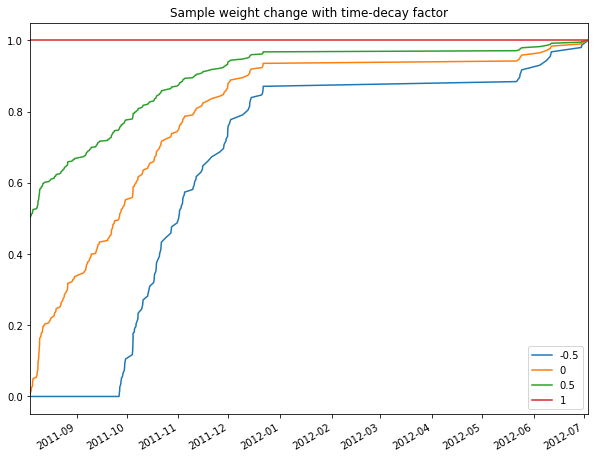

In [21]:
sample_weights.plot(figsize=(10,8), title='Sample weight change with time-decay factor')